# Optimize process

Here we simultaneously explore the audio loading and the parallelization problem.

## Input dataframe

In [1]:
from pandas import read_csv

In [2]:
df = read_csv("test_input.csv")
df.head()
df = df.head(3) # TODO: remove this line to test the whole set
df

,start_time,end_time,participant,utterance,key,language,uid
0,629.96,630.51,A,aha,/german1/5298,german,german-059-255-629960
1,398.87,399.33,A,aha,/german1/5298,german,german-059-151-398870
2,2009.10,2009.50,tx@ADUSBS,aoq,/sambas1/SBS-20111031,sambas,sambas-24-0883-2009100


## Auxiliary functions:
This adapter will help us converting our syntax (using keys) into librosa's syntax (using filenames).

In [3]:
def filename_from_key(key, data_folder = "data", ext = ".wav"):
    """ Takes the key, returns the filename """
    return data_folder + key + ext #TODO: consider improving this using os.path

### Examples

In [4]:
filename_from_key("/catalan1/ca_f02a_m05a_und")

'data/catalan1/ca_f02a_m05a_und.wav'

## Extract audio features

In [5]:
import librosa

In [6]:
def audio_from_key(key, **kwargs):
    """ Equivalent to librosa.core.load, but works with keys instead of with filenames """
    return librosa.core.load(filename_from_key(key), **kwargs)

### Example of usage

In [7]:
data, rate = audio_from_key("/catalan1/ca_f02a_m05a_und")
print(data)
print(rate)

[-1.6827690e-03 -2.3811827e-03 -2.2289073e-03 ... -1.8447537e-08
 -9.6680355e-07  0.0000000e+00]
22050


## Compare performances

In [8]:
import dask.bag as db

### Serial

In [9]:
for row in df["key"]:
    print(row)
    data, rate = audio_from_key(row)
    print(rate)

/german1/5298
22050
/german1/5298
22050
/sambas1/SBS-20111031
22050


### Parallel

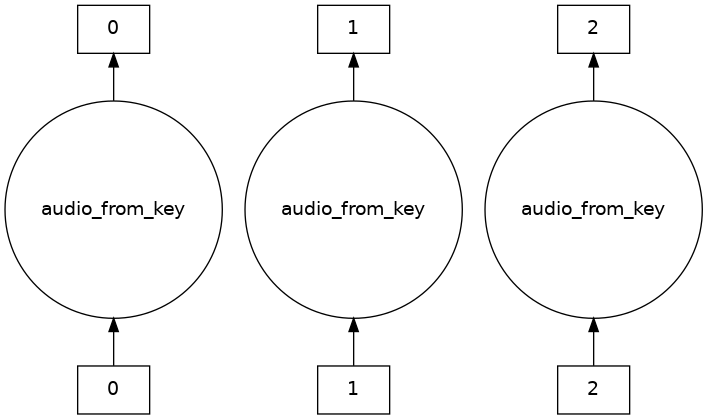

In [10]:
bag = db.from_sequence(df["key"])
bag.map(audio_from_key).visualize()

In [11]:
bag.map(audio_from_key).compute()

[(array([-0.00043917, -0.00046311, -0.00031764, ..., -0.00100527,
         -0.00074906, -0.00034924], dtype=float32),
  22050),
 (array([-0.00043917, -0.00046311, -0.00031764, ..., -0.00100527,
         -0.00074906, -0.00034924], dtype=float32),
  22050),
 (array([-0.00298155, -0.00379412, -0.00346273, ...,  0.00318763,
          0.00121096,  0.        ], dtype=float32),
  22050)]